In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
csvRoute= "../GSAF5.csv"
df = pd.read_csv(csvRoute, encoding='iso-8859-1')
df.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992,NaN,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991,NaN,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,...,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,...,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989,NaN,NaN


In [19]:
len(df.columns)

24

In [13]:
colsInWeb=['Case Number','Date','Year','Type','Country','Area','Location',
           'Activity','Name','Sex','Age','Injury','Fatal (Y/N)','Time','Species','Investigator or Source']

len(colsInWeb)

16

In [35]:
#Borrar columnas que no necesito
df = df.drop(['pdf', 'href formula', 'href','Case Number.1', 'Case Number.2', 'Unnamed: 22','Unnamed: 23', 'original order'], axis=1)
len(df.columns)

16

In [36]:
df.head()

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,Investigator or Source
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,16,Minor injury to thigh,N,13h00,NaN,"Orlando Sentinel, 9/19/2016"
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,36,Lacerations to hands,N,11h00,NaN,"Orlando Sentinel, 9/19/2016"
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,43,Lacerations to lower leg,N,10h43,NaN,"Orlando Sentinel, 9/19/2016"
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,NaN,Struck by fin on chest & leg,N,NaN,NaN,"The Age, 9/18/2016"
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,NaN,No injury: Knocked off board by shark,N,NaN,2 m shark,"The Age, 9/16/2016"


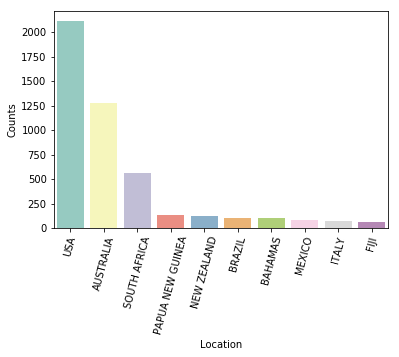

In [76]:
top10countries = df.Country.value_counts().head(10)
countries = top10countries.reset_index()
countries.columns = ['Location', 'Counts']
sns.barplot(countries.Location, countries.Counts, palette="Set3")
plt.xticks(rotation=75)
plt.show()

In [54]:
null_cols = df.isnull().sum()
null_cols[null_cols>0].sort_values(ascending=False)

Time                      3213
Species                   2934
Age                       2681
Sex                        567
Activity                   527
Location                   496
Area                       402
Name                       200
Country                     43
Injury                      27
Fatal (Y/N)                 19
Investigator or Source      15
dtype: int64

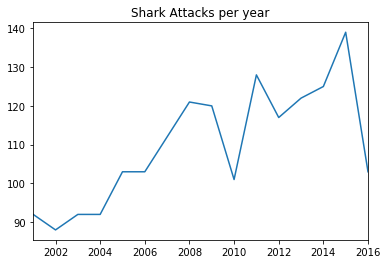

In [68]:
df['Year_cleaned'] = df[df['Year']>2000]['Year']
Years_values = df['Year_cleaned'].value_counts().sort_index()

# Investigar .plot de matplotlib
Years_values.plot(title="Shark Attacks per year")

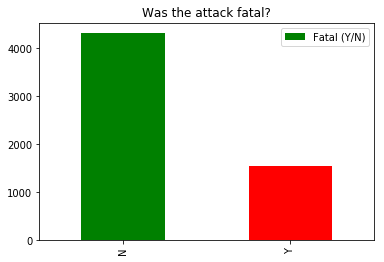

In [64]:
#La barra es el cambio de linea
df[df['Fatal (Y/N)'].isin(['Y','N'])]["Fatal (Y/N)"].value_counts()\
.plot(kind='bar', title= "Was the attack fatal?",legend = True, color= ['green','red'])